Detected users: ['User1', 'User2', 'User3', 'User8', 'User9', 'User10', 'User11', 'User12', 'User15', 'User24']
Pre counts (%): [np.float64(40.909090909090914), np.float64(59.09090909090909), np.float64(76.92307692307693), np.float64(81.53846153846153), np.float64(69.23076923076923), np.float64(77.27272727272727), np.float64(53.84615384615385), np.float64(77.27272727272727), np.float64(40.909090909090914), np.float64(63.793103448275865)]
Post counts (%): [np.float64(91.37931034482759), np.float64(82.75862068965517), np.float64(83.07692307692308), np.float64(87.6923076923077), np.float64(78.46153846153847), np.float64(96.96969696969697), np.float64(66.15384615384615), np.float64(77.27272727272727), np.float64(72.72727272727273), np.float64(82.75862068965517)]


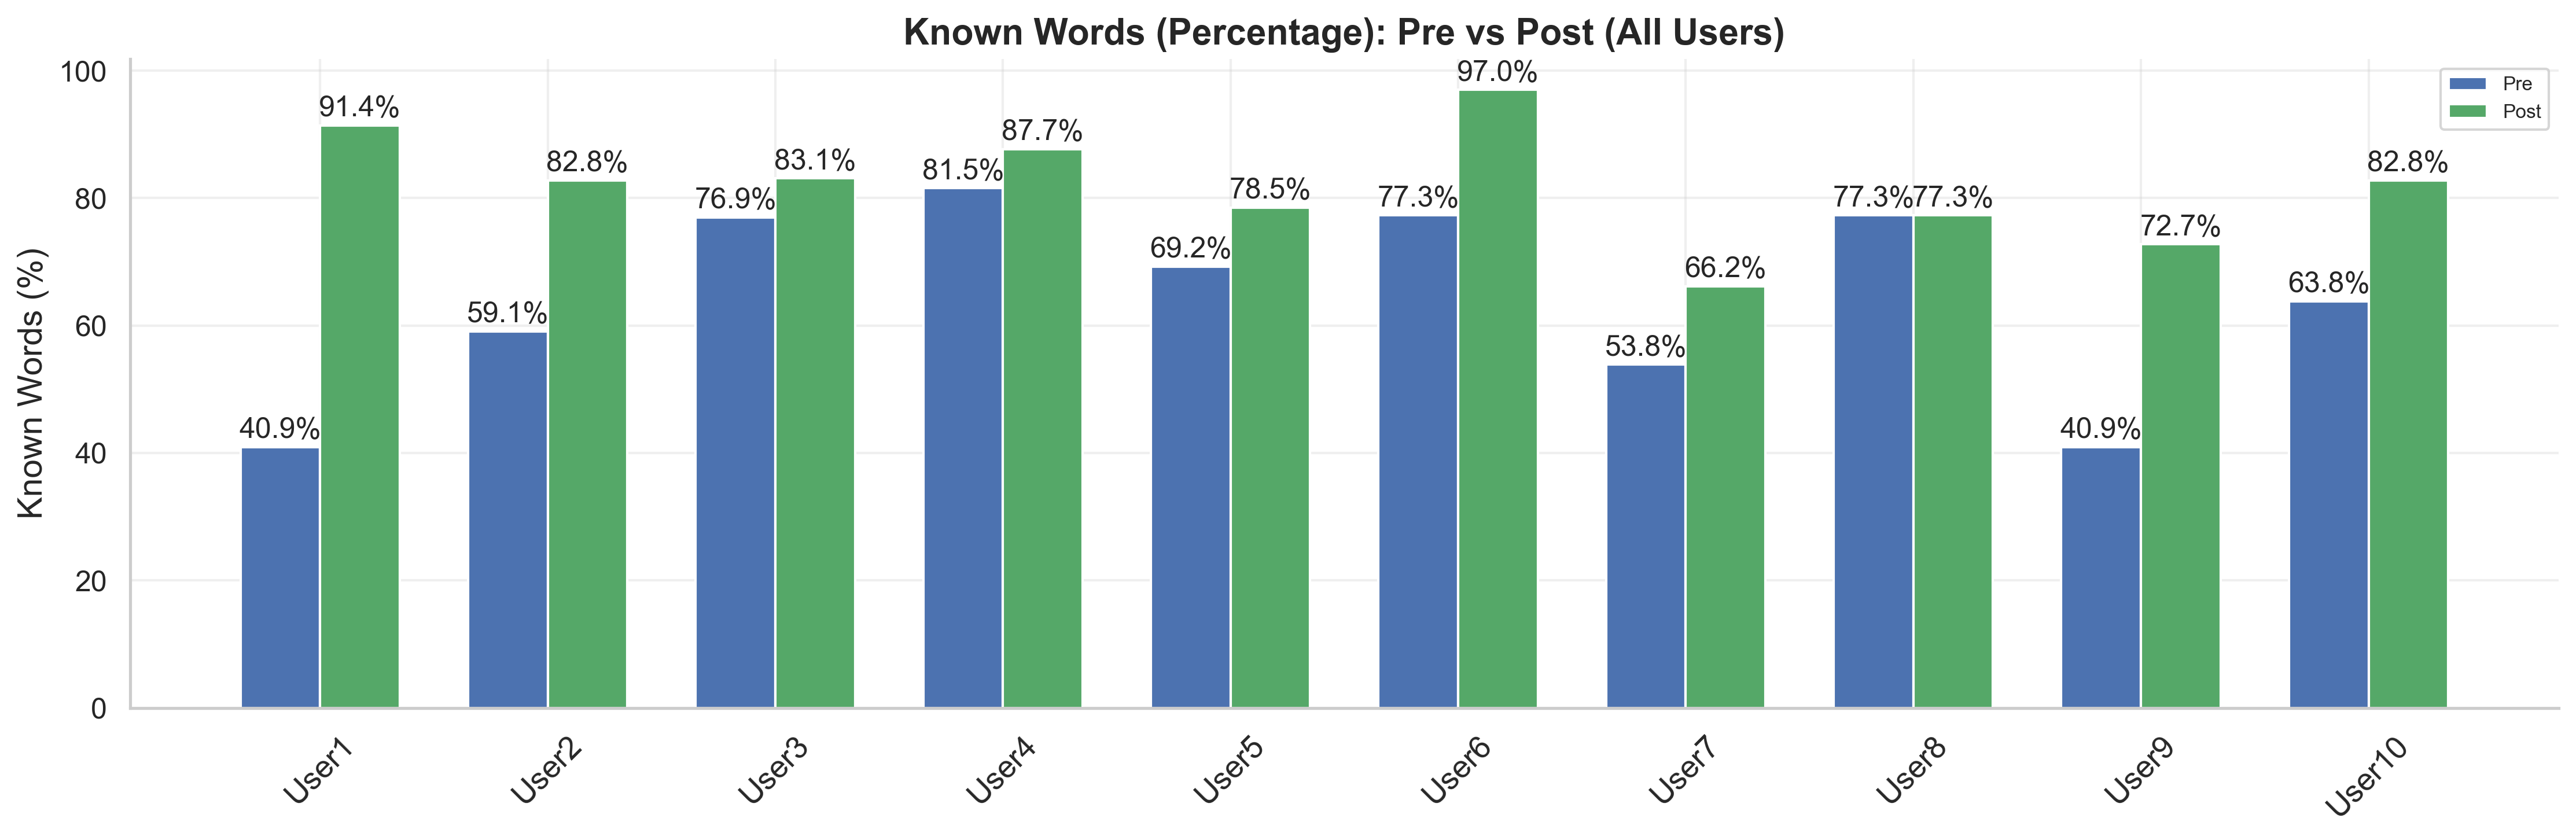

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re
from adjustText import adjust_text

plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'serif'],
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white',
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'axes.linewidth': 1.0,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.edgecolor': 'black',
    'axes.axisbelow': True,
    'xtick.bottom': True,
    'ytick.left': True,
    'grid.alpha': 0.3,
    'grid.color': 'gray'
})

# Find all pre and post files
folder = '/Users/Martina.Galletti/Downloads/dati-artis1/lexical-tests/'
pre_files = glob.glob(os.path.join(folder, 'User*-pre.csv'))
post_files = glob.glob(os.path.join(folder, 'User*-post.csv'))

# Extract user names robustly
def extract_user(filename):
    # Example filename: 'User1-pre - Foglio1.csv'
    match = re.match(r'(User\d+)', os.path.basename(filename))
    return match.group(1) if match else None

# Sort users numerically by extracting the number after 'User'
users = sorted(
    set(extract_user(f) for f in pre_files + post_files if extract_user(f)),
    key=lambda u: int(u[4:])
)

print("Detected users:", users)

pre_counts = []
post_counts = []

for user in users:
    # Find corresponding files
    pre_file = next((f for f in pre_files if user in f), None)
    post_file = next((f for f in post_files if user in f), None)

    def count_known_words(path):
        if path and os.path.exists(path):
            df = pd.read_csv(path)
            si_cols = [col for col in df.columns if 'Si' in col]
            if si_cols:
                si_col = si_cols[0]
                known = df[si_col].fillna('').str.lower().eq('x').sum()
                total = len(df)
                return known / total * 100 if total else 0  # percentage
        return 0

    pre_counts.append(count_known_words(pre_file))
    post_counts.append(count_known_words(post_file))

print("Pre counts (%):", pre_counts)
print("Post counts (%):", post_counts)

sns.set(style="whitegrid")
plt.figure(figsize=(max(7, len(users)*1.5), 5))

x = range(len(users))
width = 0.35

bar1 = plt.bar(x, pre_counts, width, label='Pre', color='#4C72B0')
bar2 = plt.bar([i + width for i in x], post_counts, width, label='Post', color='#55A868')

# Add value labels
for bars in [bar1, bar2]:
    for bar in bars:
        plt.text(
            bar.get_x() + bar.get_width()/2, 
            bar.get_height() + 0.5, 
            f'{bar.get_height():.1f}%', 
            ha='center', va='bottom', fontsize=12
        )

# Create a custom mapping for display names
custom_names = {
    'User8': 'User4',
    'User9': 'User5',
    'User10': 'User6',
    'User11': 'User7',
    'User12': 'User8',
    'User15': 'User9',
    'User24': 'User10',
}

# Use the mapping for x-axis labels
plot_labels = [custom_names.get(user, user) for user in users]

plt.xticks([i + width/2 for i in x], plot_labels, fontsize=13, rotation=45)
plt.yticks(fontsize=12)
plt.ylabel('Known Words (%)', fontsize=14)
plt.title('Known Words (Percentage): Pre vs Post (All Users)', fontsize=15, weight='bold')
plt.legend(fontsize=8, loc='upper right')
sns.despine()
plt.tight_layout()
plt.show()

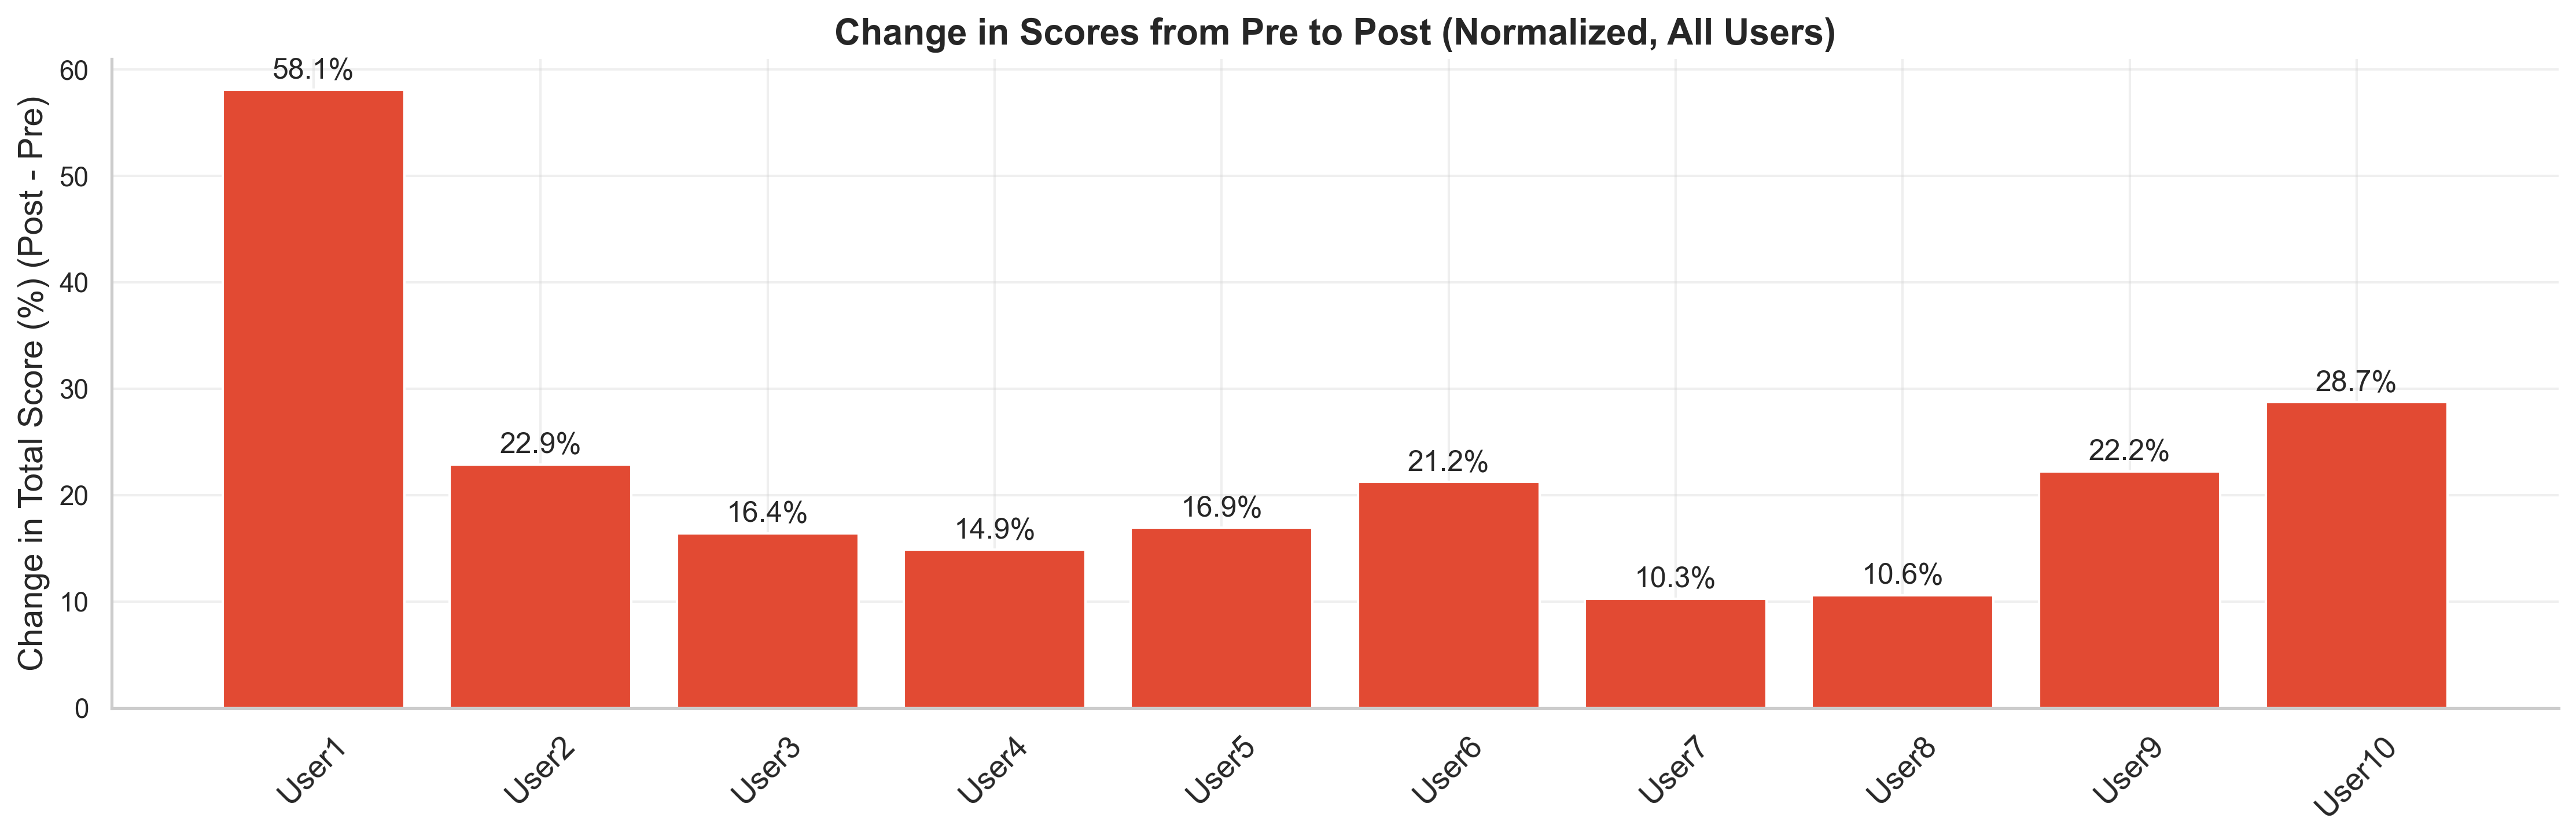

In [11]:
def extract_last_score(cell):
    """Extract the last number from a cell, or return the cell if it's a number."""
    if pd.isna(cell):
        return 0
    if isinstance(cell, (int, float)):
        return int(cell)
    numbers = re.findall(r'\d+', str(cell))
    return int(numbers[-1]) if numbers else 0

score_changes = []
score_labels = []

for user in users:
    pre_file = next((f for f in pre_files if user in f), None)
    post_file = next((f for f in post_files if user in f), None)
    pre_score = 0
    post_score = 0
    max_pre = 0
    max_post = 0

    if pre_file and os.path.exists(pre_file):
        df_pre = pd.read_csv(pre_file)
        if 'Punteggio_pre' in df_pre.columns:
            pre_scores = df_pre['Punteggio_pre'].apply(extract_last_score)
            pre_score = pre_scores.sum()
            max_pre = len(pre_scores) * pre_scores.max() if pre_scores.max() else 1
    if post_file and os.path.exists(post_file):
        df_post = pd.read_csv(post_file)
        if 'Punteggio_post' in df_post.columns:
            post_scores = df_post['Punteggio_post'].apply(extract_last_score)
            post_score = post_scores.sum()
            max_post = len(post_scores) * post_scores.max() if post_scores.max() else 1

    # Normalize scores to percentage
    pre_pct = pre_score / max_pre * 100 if max_pre else 0
    post_pct = post_score / max_post * 100 if max_post else 0
    score_changes.append(post_pct - pre_pct)
    score_labels.append(custom_names.get(user, user))

plt.figure(figsize=(max(7, len(users)*1.5), 5))
bars = plt.bar(range(len(users)), score_changes, color='#E24A33')
plt.xticks(range(len(users)), score_labels, fontsize=13, rotation=45)
plt.ylabel('Change in Total Score (%) (Post - Pre)', fontsize=14)
plt.title('Change in Scores from Pre to Post (Normalized, All Users)', fontsize=15, weight='bold')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + np.sign(bar.get_height())*0.5,
             f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()

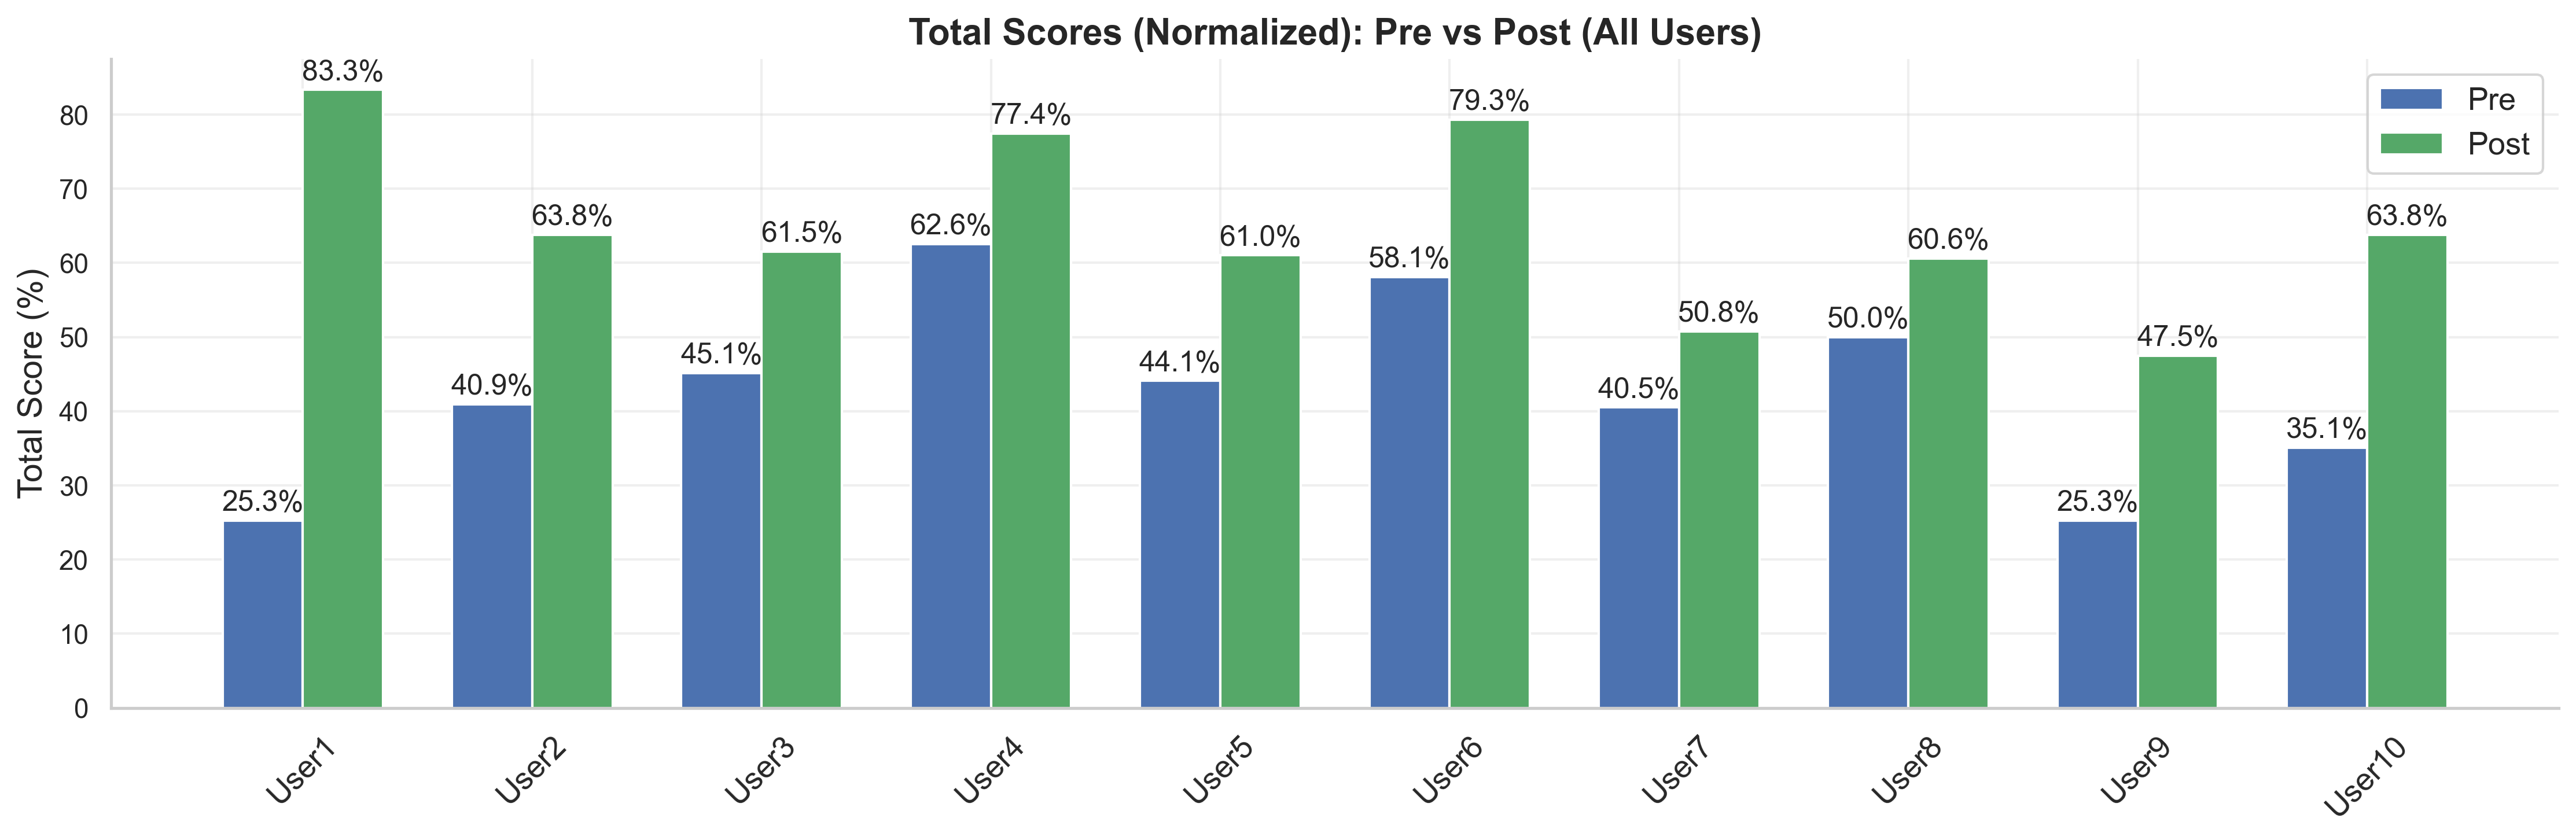

In [9]:
score_pre = []
score_post = []
score_labels = []

for user in users:
    pre_file = next((f for f in pre_files if user in f), None)
    post_file = next((f for f in post_files if user in f), None)
    pre_score = 0
    post_score = 0
    max_pre = 0
    max_post = 0

    if pre_file and os.path.exists(pre_file):
        df_pre = pd.read_csv(pre_file)
        if 'Punteggio_pre' in df_pre.columns:
            pre_scores = df_pre['Punteggio_pre'].apply(extract_last_score)
            pre_score = pre_scores.sum()
            max_pre = len(pre_scores) * pre_scores.max()  # or set your logic for max per user
    if post_file and os.path.exists(post_file):
        df_post = pd.read_csv(post_file)
        if 'Punteggio_post' in df_post.columns:
            post_scores = df_post['Punteggio_post'].apply(extract_last_score)
            post_score = post_scores.sum()
            max_post = len(post_scores) * post_scores.max()  # or set your logic for max per user

    # Avoid division by zero
    score_pre.append(pre_score / max_pre * 100 if max_pre else 0)
    score_post.append(post_score / max_post * 100 if max_post else 0)
    score_labels.append(custom_names.get(user, user))

plt.figure(figsize=(max(7, len(users)*1.5), 5))
x = np.arange(len(users))
width = 0.35

bar1 = plt.bar(x, score_pre, width, label='Pre', color='#4C72B0')
bar2 = plt.bar(x + width, score_post, width, label='Post', color='#55A868')

for bars in [bar1, bar2]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=12)

plt.xticks(x + width/2, score_labels, fontsize=13, rotation=45)
plt.ylabel('Total Score (%)', fontsize=14)
plt.title('Total Scores (Normalized): Pre vs Post (All Users)', fontsize=15, weight='bold')
plt.legend(fontsize=13)
sns.despine()
plt.tight_layout()
plt.show()

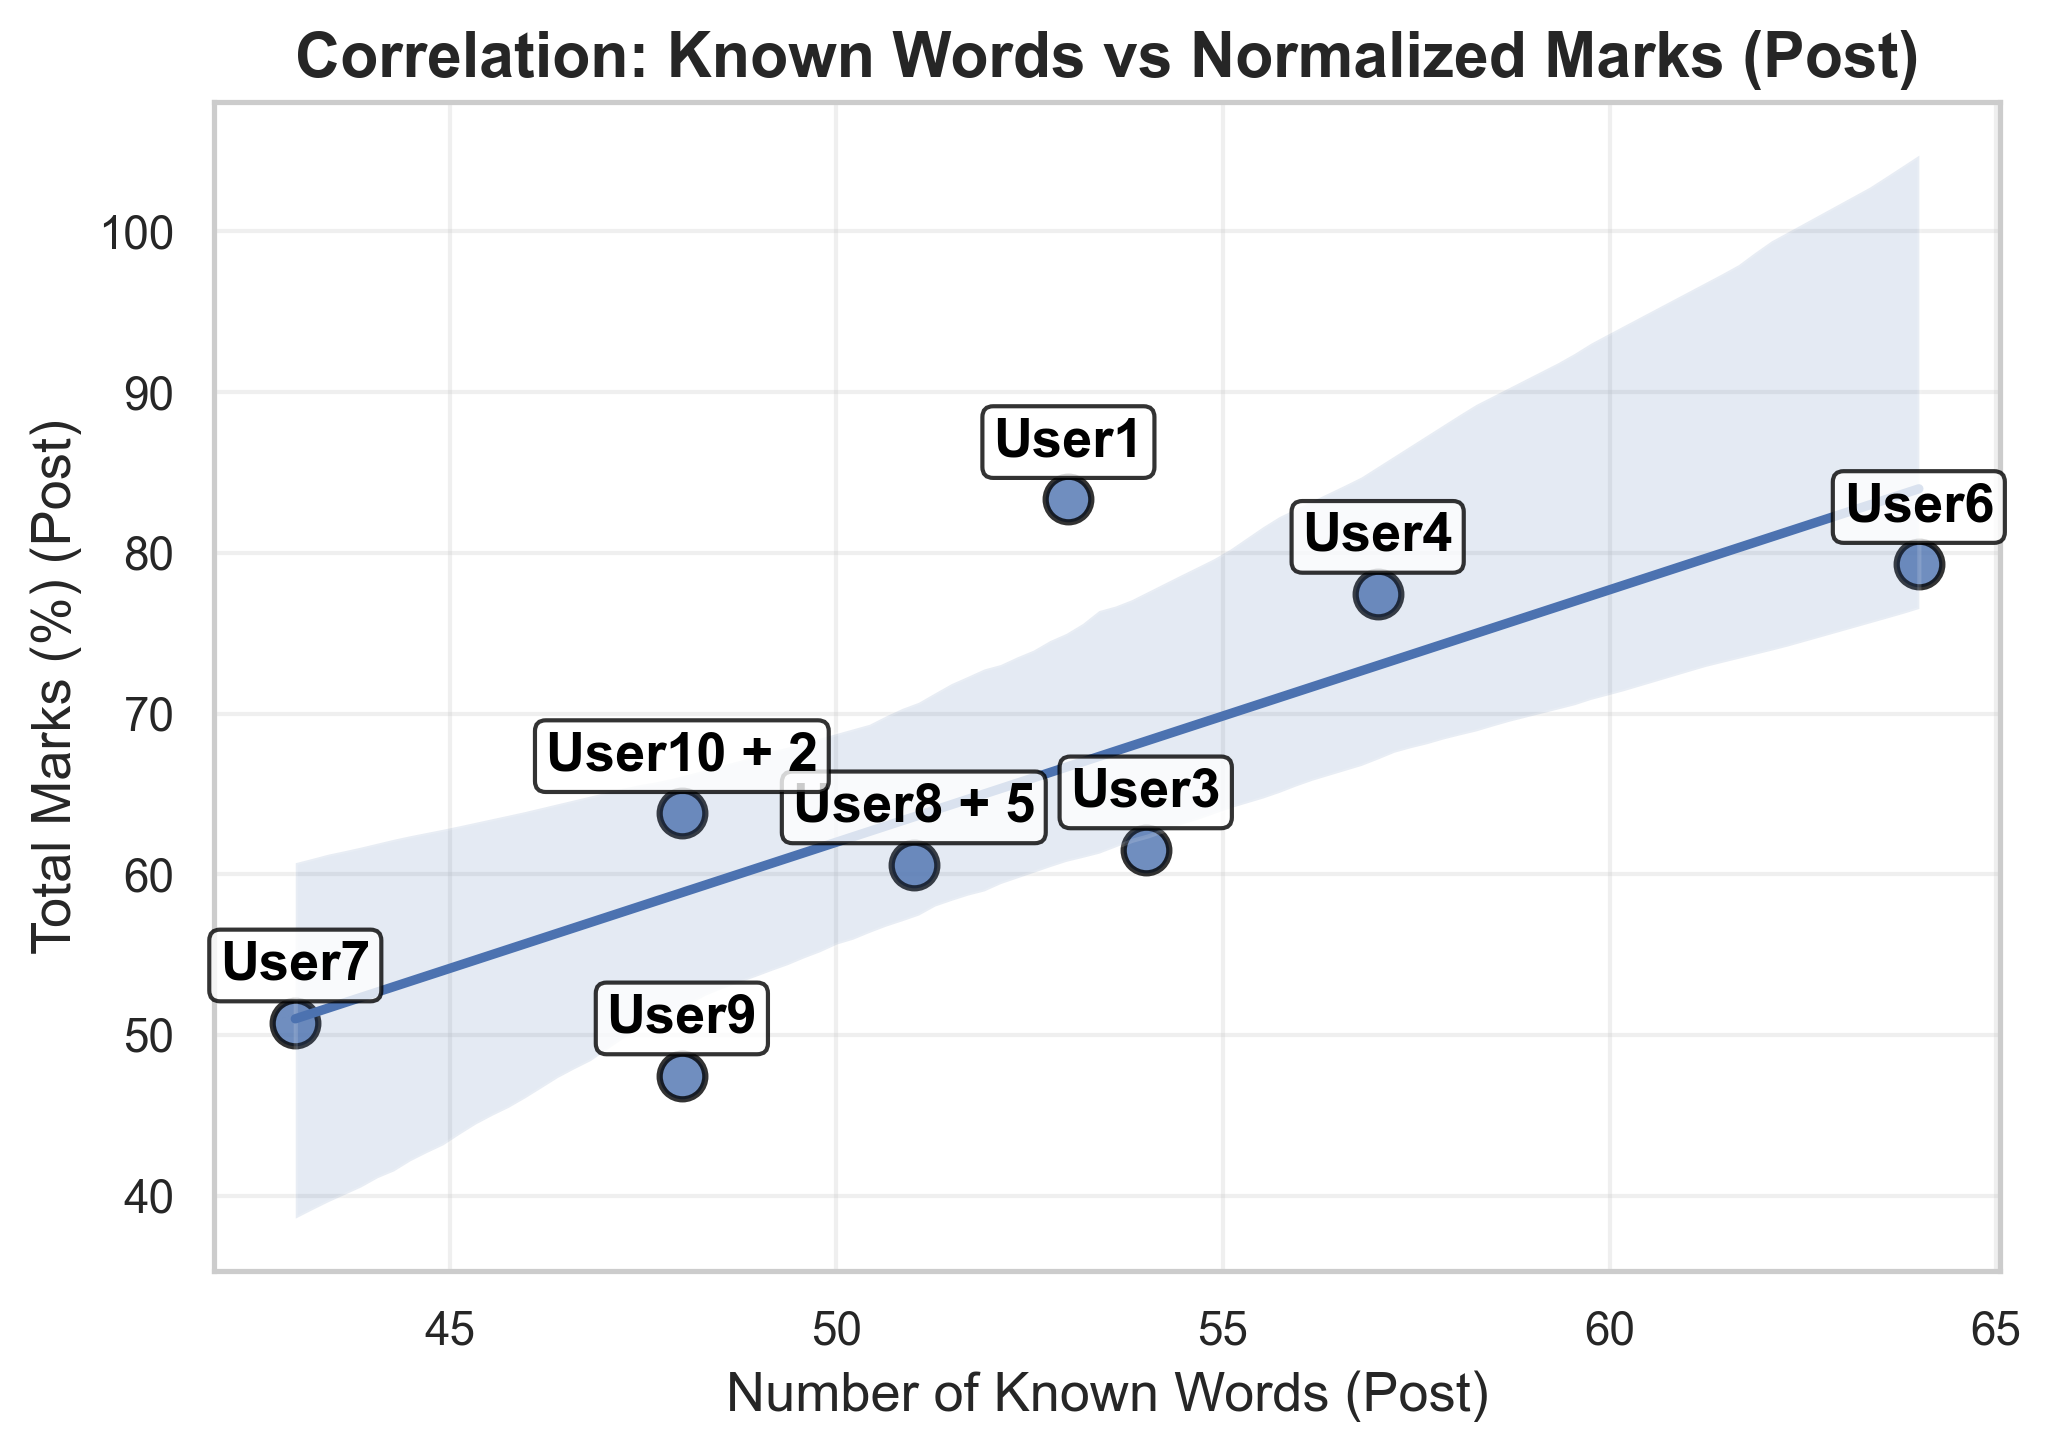

In [24]:
from scipy.stats import pearsonr

# Calculate known words and normalized marks for each user (post)
known_words_post = []
marks_post = []
labels = []

for user in users:
    post_file = next((f for f in post_files if user in f), None)
    if post_file and os.path.exists(post_file):
        df_post = pd.read_csv(post_file)
        # Known words: count 'x' or 'X' in Si_post
        si_cols = [col for col in df_post.columns if 'Si' in col]
        if si_cols:
            si_col = si_cols[0]
            known_count = df_post[si_col].fillna('').str.lower().eq('x').sum()
        else:
            known_count = 0
        # Marks: sum last number in Punteggio_post, normalize by max possible
        if 'Punteggio_post' in df_post.columns:
            post_scores = df_post['Punteggio_post'].apply(extract_last_score)
            marks = post_scores.sum()
            max_marks = len(post_scores) * post_scores.max() if post_scores.max() else 1
            marks_pct = marks / max_marks * 100
        else:
            marks_pct = 0
        known_words_post.append(known_count)
        marks_post.append(marks_pct)
        labels.append(custom_names.get(user, user))

# Calculate correlation
r, p = pearsonr(known_words_post, marks_post)
exclude = ["User2", "User5"]

filtered_known = []
filtered_marks = []
filtered_labels = []

for k, m, l in zip(known_words_post, marks_post, labels):
    if l not in exclude:
        filtered_known.append(k)
        filtered_marks.append(m)
        filtered_labels.append(l)

plt.figure(figsize=(7, 5))
sns.regplot(
    x=filtered_known,
    y=filtered_marks,
    scatter_kws={'s': 120, 'edgecolor': 'black', 'linewidths': 1.5},
    color='#4C72B0'
)

for i, label in enumerate(filtered_labels):
    if label == "User10":
        label = "User10 + 2"
    elif label == "User8":
        label = "User8 + 5"
    plt.text(
        filtered_known[i], filtered_marks[i] + 2, label,
        fontsize=13, fontweight='bold',
        ha='center', va='bottom',
        color='black',
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.8, boxstyle='round,pad=0.2')
    )

plt.xlabel('Number of Known Words (Post)', fontsize=13)
plt.ylabel('Total Marks (%) (Post)', fontsize=13)
plt.title('Correlation: Known Words vs Normalized Marks (Post)', fontsize=15, weight='bold')
plt.tight_layout()
plt.show()